In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import numpy as np
import pandas as pd

## Merge and sort data by datetime

In [4]:
def combine_data(outcomes_path, plr_path):
    outcomes_all = pd.read_csv(outcomes_path, index_col=0)
    outcomes_plr = pd.read_csv(plr_path, index_col=0)
    
    outcomes_all = outcomes_all[
        ['id', 'winner', 'loser']
    ].dropna().astype(np.int64).drop_duplicates().reset_index(drop=True)
    
    outcomes_plr = outcomes_plr[
        outcomes_plr.contest.isin(outcomes_all.id)
    ].reset_index(drop=True).rename(columns={'winner':'winner_plr', 'loser':'loser_plr'})
    
    winner_ids = []
    loser_ids = []
    outcomes_byid = dict(tuple(outcomes_all.groupby('id')))

    for i, row in outcomes_plr.iterrows():
        outcome_data = outcomes_byid[row['contest']].iloc[0]
        winner_ids.append(outcome_data['winner'])
        loser_ids.append(outcome_data['loser'])
        
    outcomes = outcomes_plr.copy()
    outcomes['winner_id'] = winner_ids
    outcomes['loser_id'] = loser_ids
    outcomes['time'] = pd.to_datetime(outcomes_plr['time'])
    outcomes = outcomes.sort_values(by='time', ascending=True)
    return outcomes

## Add player n_games to data

In [5]:
def add_n_exp(outcomes):
    n_exp = {}
    winner_n_exp = []
    loser_n_exp = []

    for i,row in outcomes.iterrows():
        winner_id, loser_id = row['winner_id'], row['loser_id']

        if winner_id in n_exp:
            n_exp[winner_id]+=1
        else:
            n_exp[winner_id]=1

        if loser_id in n_exp:
            n_exp[loser_id]+=1
        else:
            n_exp[loser_id]=1

        winner_n_exp.append(n_exp[winner_id])
        loser_n_exp.append(n_exp[loser_id])
        
    outcomes_exp = outcomes.copy()
    outcomes_exp['winner_n'] = winner_n_exp
    outcomes_exp['loser_n'] = loser_n_exp
    return outcomes_exp[['time', 'winner_plr', 'winner_n', 'winner_id', 'loser_plr', 'loser_n', 'loser_id']]

## Scale data to (0,1)

In [6]:
def min_max_scaler(value, minimum, maximum, lo=0, hi=1):
    return (value-minimum)/(maximum-minimum)*(hi-lo)+lo

def scale_ratings(outcomes):
    maximum_plr = max([outcomes['winner_plr'].max(), outcomes['loser_plr'].max()])
    minimum_plr = min([outcomes['winner_plr'].min(), outcomes['loser_plr'].min()])
    outcomes['winner_plr'] = outcomes['winner_plr'].apply(lambda x: min_max_scaler(x, minimum_plr, maximum_plr))
    outcomes['loser_plr'] = outcomes['loser_plr'].apply(lambda x: min_max_scaler(x, minimum_plr, maximum_plr))

    maximum_n = max([outcomes['winner_n'].max(), outcomes['loser_n'].max()])
    minimum_n = min([outcomes['winner_n'].min(), outcomes['loser_n'].min()])
    outcomes['winner_n'] = outcomes['winner_n'].apply(lambda x: min_max_scaler(x, minimum_n, maximum_n))
    outcomes['loser_n'] = outcomes['loser_n'].apply(lambda x: min_max_scaler(x, minimum_n, maximum_n))
    return outcomes.drop(columns=['time'])

## Make features with player history

In [7]:
import copy
from tqdm import tqdm

def unique(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

def make_features(outcomes, max_len = 20):
    features = []

    player_states = {
        k:{
            'plr':None, 'n':None, 
            'opp_plr':[0.]*max_len, 'opp_n':[0.]*max_len, 
            'opp_outcome':[0]*max_len, 'mask':[0]*max_len
        }
        for k in unique(outcomes['winner_id'].unique().tolist()+outcomes['loser_id'].unique().tolist())
    }

    for i,row in tqdm(outcomes.iterrows()):
        player_states[row['winner_id']]['plr'] = row['winner_plr']
        player_states[row['winner_id']]['n'] = row['winner_n']

        player_states[row['loser_id']]['plr'] = row['loser_plr']
        player_states[row['loser_id']]['n'] = row['loser_n']

        features.append((copy.deepcopy(player_states[row['winner_id']]), copy.deepcopy(player_states[row['loser_id']])))

        player_states[row['winner_id']]['opp_plr'].append(row['loser_plr'])
        player_states[row['winner_id']]['opp_n'].append(row['winner_n'])
        player_states[row['winner_id']]['opp_outcome'].append(1)
        player_states[row['winner_id']]['mask'].append(1)

        player_states[row['loser_id']]['opp_plr'].append(row['winner_plr'])
        player_states[row['loser_id']]['opp_n'].append(row['loser_n'])
        player_states[row['loser_id']]['opp_outcome'].append(0)
        player_states[row['loser_id']]['mask'].append(1)

        for var in ['opp_plr', 'opp_n', 'opp_outcome', 'mask']:
            player_states[row['winner_id']][var] = player_states[row['winner_id']][var][-max_len:]
            player_states[row['loser_id']][var] = player_states[row['loser_id']][var][-max_len:]
    return features

## Make features and split train/test set

In [ ]:
import os
import pickle

def split_features(features):
    n_train = int(len(features)*0.9)
    train_features = features[:n_train]
    test_features = features[n_train:]
    
    with open('datasets/train.pkl', "wb") as f:
        pickle.dump(train_features, f)
        
    with open('datasets/test.pkl', "wb") as f:
        pickle.dump(test_features, f)

def load_features(data_dir='.'):
    with open(os.path.join(data_dir, 'datasets/train.pkl'), "rb") as f:
        train_features = pickle.load(f)
        
    with open(os.path.join(data_dir, 'datasets/test.pkl'), "rb") as f:
        test_features = pickle.load(f)
    return train_features, test_features

## Clean Data

In [8]:
outcomes = combine_data('datasets/outcomes_madden.csv', 'datasets/ps4-madden21.csv')
outcomes.to_csv('datasets/outcomes_madden_sorted.csv', index=False)

In [9]:
outcomes = add_n_exp(pd.read_csv('datasets/outcomes_madden_sorted.csv'))
outcomes.to_csv('datasets/outcomes_n_exp.csv', index=False)

### Max context length = 75 games

In [10]:
outcomes = pd.read_csv('datasets/outcomes_n_exp.csv') 
outcomes = scale_ratings(outcomes)
features = make_features(outcomes, max_len=75)

split_features(features)

143467it [01:21, 1751.02it/s]


## Define dataset and collator

In [11]:
import torch
import numpy as np

def one_hot(y, size):
    y_onehot = torch.FloatTensor(y.size(0), size)
    y_onehot.zero_()
    y_onehot.scatter_(1, y, 1).type_as(y)
    return y_onehot

class PlayerDataset(torch.utils.data.Dataset):
    def __init__(self, features):
        self.features = features 

    def __len__(self):
        return len(self.features)

    def __getitem__(self, i):
        if np.random.uniform(0,1)<0.5:
            return {'p1':self.features[i][0], 'p2':self.features[i][1], 'label':[0]}
        else:
            return {'p1':self.features[i][1], 'p2':self.features[i][0], 'label':[1]}

class PlayerDataCollator:
    def __init__(self, device):
        self.device = device
        
    def _historize(self, features):
        opp_plrn = torch.einsum('ijk->ikj', torch.tensor([[x['opp_plr'], x['opp_n']] for x in features], dtype=torch.float))
        opp_outcome = torch.cat([
            one_hot(torch.tensor(x['opp_outcome']).unsqueeze(-1), 2).unsqueeze(0) 
            for x in features], dim=0)
        return torch.cat([opp_plrn, opp_outcome], dim=-1)
    
    def _playerize(self, player):
        return {
            'plrn':torch.tensor([[[x['plr'], x['n']]] for x in player], dtype=torch.float).to(self.device), 
            'exp':self._historize(player).to(self.device), 
            'mask':torch.tensor([x['mask'] for x in player], dtype=torch.long).to(self.device)
        }
        
    def __call__(self, features):
        batch = {
            'p1':self._playerize([x['p1'] for x in features]),
            'p2':self._playerize([x['p2'] for x in features]),
            'label':torch.tensor([x['label'] for x in features]).to(self.device)
        }
        return batch

## Define torch model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=50):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

class NonLinear(nn.Module):
    def __init__(self, d_in, d_hid, d_out, dropout=0.):
        super(NonLinear, self).__init__()
        self.w_1 = nn.Linear(d_in, d_hid)
        self.w_2 = nn.Linear(d_hid, d_out)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, x_mask=None):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    
class AttentionShift(nn.Module):
    def __init__(self, d_query, d_key, d_att):
        super(AttentionShift, self).__init__()
        self.position = PositionalEncoding(d_key, dropout=0.0)
        
        self.p = nn.Parameter(torch.FloatTensor(d_query, d_key))
        self.q = nn.Parameter(torch.FloatTensor(d_key, d_att))
        self.k = nn.Parameter(torch.FloatTensor(d_key, d_att))
        self.v = nn.Parameter(torch.FloatTensor(d_key, d_key))
        
        self.ff = NonLinear(d_key, 2*d_key, d_key)
        self.norm = nn.LayerNorm(d_key)
        self.attn = None
        self.mask = None
        
        self.init_normed()
    
    def init_normed(self):
        nn.init.xavier_uniform_(self.p)
        nn.init.xavier_uniform_(self.q)
        nn.init.xavier_uniform_(self.k)
        nn.init.xavier_uniform_(self.v)
        
    def forward(self, plrn, exp, mask):
        p = self.position(torch.einsum("nsq,qa->nsa", plrn, self.p))
        q = torch.einsum("nsq,qa->nsa", p, self.q)
        k = torch.einsum("ntk,ka->nta", exp, self.k)
        v = torch.einsum("ntk,kq->ntq", exp, self.v)
        
        attn_score = torch.einsum("nsa,nta->nst", q, k)
        
        if mask is not None:
            attn_score += 1e15*(mask-1).unsqueeze(1)
            self.mask = (mask-1).unsqueeze(1)
        
        attn_prob = F.softmax(attn_score, dim=-1)
        self.attn = attn_prob
        
        out = torch.einsum("nst,ntq->nsq", attn_prob, v)
        return self.ff(self.norm(p+out))
    
class PlayerClassifier(nn.Module):
    def __init__(self, d_query, d_key, d_att, num_labels=2):
        super(PlayerClassifier, self).__init__()
        self.embed = AttentionShift(d_query, d_key, d_att)
        self.proj = nn.Linear(3*d_key, num_labels)
        self.num_labels = num_labels
        
    def forward(self, x):
        p1 = self.embed(**x['p1']).squeeze()
        p2 = self.embed(**x['p2']).squeeze()
        
        logits = self.proj(torch.cat([p1, p2, torch.abs(p1-p2)], dim=-1))
        labels = x['label']
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return logits, labels, loss

## Train Model

In [13]:
model = PlayerClassifier(d_query=2, d_key=4, d_att=4)
model.to(device)
# model = nn.DataParallel(mod)

train_features, test_features = load_features()

trainset = PlayerDataset(train_features)
trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=100, 
    shuffle=False, 
    collate_fn=PlayerDataCollator(device=device)
)

testset = PlayerDataset(test_features)
testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=100, 
    shuffle=False, 
    collate_fn=PlayerDataCollator(device=device)
)
pass;

In [14]:
print_every = 5
epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

In [16]:
import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

In [17]:
def get_eval_df(model, loader):
    model.eval();
    model_preds, batch_labels = [], []
    plr1s, plr2s = [], []
    n1s, n2s = [], []
    losses = []

    for inputs in loader:
        plr1s.extend(inputs['p1']['plrn'][:,0,0].tolist())
        plr2s.extend(inputs['p2']['plrn'][:,0,0].tolist())
        n1s.extend(inputs['p1']['plrn'][:,0,1].tolist())
        n2s.extend(inputs['p2']['plrn'][:,0,1].tolist())
        
        logits, labels, loss = model(inputs)
        model_preds.extend(logits.cpu().detach().max(dim=-1).indices.tolist())
        batch_labels.extend(labels.cpu().detach().squeeze().tolist())
        losses.append(loss.cpu().detach().item())

    mean_loss = np.mean(losses)
    
    eval_df = pd.DataFrame({
        'plr1':plr1s,
        'n1':n1s,
        'plr2':plr2s,
        'n2':n2s,
        'label':batch_labels,
        'model_pred':model_preds
    })
    eval_df['plr_pred'] = ((eval_df['plr1']-eval_df['plr2'])<0)*1

    return eval_df, mean_loss

In [18]:
time_start = datetime.datetime.now()
print('Start Time: %s'%time_start.strftime('%H:%M:%S'))

for epoch in range(0, epochs):
    epoch_start = datetime.datetime.now()
    model.train();
    train_loss = 0.0
    train_nbatches = 0
    
    for inputs in trainloader:
        logits, labels, loss = model(inputs)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += float(loss)
        train_nbatches += 1
    train_loss/=train_nbatches
    
    model.eval();
    with torch.no_grad():
        df, test_loss = get_eval_df(model, testloader)

        model_acc = accuracy_score(df.label, df.model_pred)
        plr_acc = accuracy_score(df.label, df.plr_pred)

        if epoch%print_every == 0:
            print('Epoch {} || Train Loss: {:.3f} || Loss: {:.3f} || Acc: {:.3f} || PLR Acc: {:.3f}'.format(
                str(epoch).zfill(3), train_loss, test_loss, model_acc, plr_acc)
                 )
time_finish = datetime.datetime.now()
print('End Time: %s'%time_finish.strftime('%H:%M:%S'))
print('Completed in %s seconds'%(time_finish-time_start).total_seconds())
pass;

Start Time: 10:29:50
Epoch 000 || Train Loss: 0.663 || Loss: 0.642 || Acc: 0.628 || PLR Acc: 0.599
Epoch 005 || Train Loss: 0.644 || Loss: 0.632 || Acc: 0.643 || PLR Acc: 0.598
Epoch 010 || Train Loss: 0.642 || Loss: 0.629 || Acc: 0.645 || PLR Acc: 0.599
Epoch 015 || Train Loss: 0.641 || Loss: 0.628 || Acc: 0.647 || PLR Acc: 0.598
Epoch 020 || Train Loss: 0.640 || Loss: 0.628 || Acc: 0.646 || PLR Acc: 0.597
Epoch 025 || Train Loss: 0.640 || Loss: 0.627 || Acc: 0.646 || PLR Acc: 0.597
Epoch 030 || Train Loss: 0.640 || Loss: 0.627 || Acc: 0.646 || PLR Acc: 0.598
Epoch 035 || Train Loss: 0.640 || Loss: 0.627 || Acc: 0.645 || PLR Acc: 0.598
Epoch 040 || Train Loss: 0.640 || Loss: 0.627 || Acc: 0.645 || PLR Acc: 0.599
Epoch 045 || Train Loss: 0.640 || Loss: 0.627 || Acc: 0.645 || PLR Acc: 0.599
End Time: 10:40:35
Completed in 644.754964 seconds


### Not sure why PLR accuracy changes by 0.001-0.002 between epochs

In [19]:
import matplotlib.pyplot as plt

df, loss = get_eval_df(model, testloader)
df['n_min'] = df[['n1','n2']].min(axis=1)

n_min = []
model_acc = []
plr_acc = []
bin_err = []

for bin_start in np.arange(0, 1, 0.1):
    bin_end = bin_start+0.1
    
    df_bin = df[(df['n_min']>=bin_start)&(df['n_min']<bin_end)]
    
    n_min.append(bin_start)
    model_acc.append(accuracy_score(df_bin.label, df_bin.model_pred))
    plr_acc.append(accuracy_score(df_bin.label, df_bin.plr_pred))
    bin_err.append(1/(len(df_bin)+1e-15))

/home/mpark/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/mpark/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


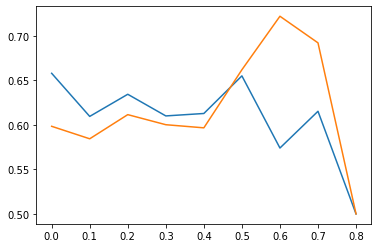

In [20]:
plt.plot(n_min, model_acc)
plt.plot(n_min, plr_acc)

### Not sure why PLR beats attention when many games have been observed.. but the number of such games is small so attention beats PLR overall

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Experience level of less expd player')

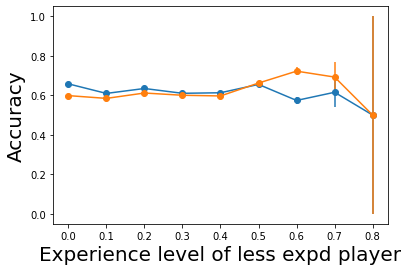

In [21]:
plt.errorbar(n_min, model_acc, yerr=bin_err, fmt='-o')
plt.errorbar(n_min, plr_acc, yerr=bin_err, fmt='-o')
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Experience level of less expd player', fontsize=20)

In [ ]:
blah

## Scratch (heat plot)

In [ ]:
from collections import Counter
import seaborn as sns

def count_tp_fn(outcomes):
    win_preds = (outcomes.winner_plr-outcomes.loser_plr).apply(lambda x: int(x/np.abs(x)) if x!=0 else 0)
    tp = Counter(win_preds)[1]
    fn = Counter(win_preds)[-1]
    return tp, fn
    
def count_tn_fp(outcomes):
    lose_preds = (outcomes.loser_plr-outcomes.winner_plr).apply(lambda x: int(x/np.abs(x)) if x!=0 else 0)
    tn = Counter(win_preds)[1]
    fp = Counter(win_preds)[-1]
    return tn, fp

def compute_acc(outcomes):
    tp, fn = count_tp_fn(outcomes)
    return tp/(tp+fn+1e-15)

def get_accuracy_matrix(outcomes):
    binned = outcomes.groupby(by=['winner_n', 'loser_n']).apply(lambda x: compute_acc(x))
    
    acc_mat = np.zeros(
        (outcomes.winner_n.max(), outcomes.loser_n.max())
    )

    for x in binned.items():
        acc_mat[x[0][0]-1, x[0][1]-1] = x[1]
    return acc_mat

In [ ]:
sns.heatmap(get_accuracy_matrix(outcomes)[:30,:30])